## Loan Prediction

### Objectives:
* Classify loan prediction by using Logistic Regession
* Show how Newton Raphson Method or Gradient Descent can be used to optimize the algorithm
* Plot ROC curves for different splits of the training set

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

In [2]:
# Set random seed
np.random.seed(144)

In [3]:
train = pd.read_csv('./data/train_u6lujuX.csv')
test = pd.read_csv('./data/test_Y3wMUE5.csv')
sub = pd.read_csv('./data/Sample_Submission_ZAuTl8O.csv')

In [4]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y


In [5]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110,360,1,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126,360,1,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208,360,1,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100,360,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78,360,1,Urban


In [6]:
# check to see if there is an overlap in loan ids among training and test examples
len(set(train.Loan_ID) & set(test.Loan_ID))

0

In [7]:
# Set Loan Id as index
train = train.set_index('Loan_ID')
test = test.set_index('Loan_ID')

In [8]:
train.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

** Class Imbalance **

In [9]:
test_loan_ids = test.index

## One Hot Encoding

In [10]:
features = train.columns.drop('Loan_Status')

target = train.Loan_Status
train = train[features].T.to_dict().values()

test = test.T.to_dict().values()

In [11]:
transformer = DictVectorizer(sparse=False)

train = transformer.fit_transform(train)
test = transformer.transform(test)

In [12]:
# fill missing values with -1
X = pd.DataFrame(train)
test = pd.DataFrame(test)

y = pd.Series(target)

In [13]:
X = X.fillna(-1)
test = test.fillna(-1)

In [14]:
y = (y=='Y').astype(np.int)

## Cross validation scores

In [ ]:
skf = StratifiedKFold(y.values, n_folds=5, random_state=44)
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [ ]:
def get_roc_scores(X, y, cv):
    return [
        cross_val_score(LogisticRegression(C=c), X, y, cv=cv, scoring='roc_auc').mean()
        for c in C_grid
    ]

roc_scores_by_C = get_roc_scores(X, y, skf)

In [ ]:
plt.plot(C_grid, roc_scores_by_C)
plt.xlabel('C')
plt.ylabel('ROC AUC Score')
plt.title('Relationship between C and ROC AUC Score');

** Best performing value for C **

In [ ]:
C_grid[np.argmax(roc_scores_by_C)]

In [ ]:
# Now lets scale the input vector and then perform the analysis again
X = scale(X)

roc_scores_by_C = get_roc_scores(X, y, skf)

In [ ]:
plt.plot(C_grid, roc_scores_by_C)
plt.xlabel('C')
plt.ylabel('ROC AUC Score')
plt.title('Relationship between C and ROC AUC Score');

In [ ]:
C_grid[np.argmax(roc_scores_by_C)]

** Very stable cv score **

## Lets see whether choice of solver effects prediction score or not

In [ ]:
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag']

def get_roc_scores_solver(X, y, cv):
    return [
        cross_val_score(LogisticRegression(C=0.1, solver=solver), X, y, cv=cv, scoring='roc_auc').mean()
        for solver in solver_list
    ]

roc_scores_by_solver = get_roc_scores_solver(X, y, skf)

In [ ]:
plt.plot(np.arange(0, 4), roc_scores_by_solver)
plt.xticks(np.arange(0, 4), solver_list, rotation='vertical')
plt.xlabel('Solver')
plt.ylabel('ROC AUC Score')
plt.title('Relationship between solver and ROC AUC Score');

** For small datasets like this one liblinear is a good choice **

## Let's see how roc-auc score varies on different train-test splits

In [ ]:
def get_roc_by_splits(X, y):
    seeds = [44, 123, 279, 512, 1279, 3022]
    clf = LogisticRegression(C=0.1)
    cv_scores = []
    oos_scores = []
    
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.15)
        
        skf = StratifiedKFold(y_train, n_folds=5, random_state=44)
        mean_cv_score = cross_val_score(clf, X_train, y_train, cv=skf, scoring='roc_auc').mean()
        cv_scores.append(mean_cv_score)
        
        clf.fit(X_train, y_train)
        preds = clf.predict_proba(X_test)[:, 1]
        oos_scores.append(roc_auc_score(y_test, preds))
    
    return (seeds, cv_scores, oos_scores)

In [ ]:
seeds, cv_scores, oos_scores = get_roc_by_splits(X, y)

In [ ]:
plt.plot(seeds, cv_scores)
plt.xlabel('Seed value for Train Test Split')
plt.ylabel('Mean CV score (5-fold)')
plt.title('Relationship between different different seed values and cv scores');

In [ ]:
plt.plot(seeds, oos_scores)
plt.xlabel('Seed value for train test split')
plt.ylabel('Out of sample score ')
plt.title('Relationship between different splits and oos score');

## Plot ROC Curves

In [ ]:
def get_roc_dfs(X, y):
    seeds = [44, 123, 279, 512, 1279, 3022]
    clf = LogisticRegression(C=0.1)
    
    roc_dfs = []
    
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.15)
        
        clf.fit(X_train, y_train)
        fpr, tpr, _ = roc_curve(y_test, preds)
        
        roc_dfs.append(pd.DataFrame(dict(fpr=fpr, tpr=tpr)))
        
    return roc_dfs

In [ ]:
roc_dfs = get_roc_dfs(X, y)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
row_index = 0
col_index = 0

for i in range(len(roc_dfs)):    
    ax[row_index][col_index].plot(roc_dfs[i].fpr, roc_dfs[i].tpr)
    ax[row_index][col_index].plot(ax[row_index][col_index].get_xlim(), ax[row_index][col_index].get_ylim(), ls="--", c=".3")
    ax[row_index][col_index].set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1));

    col_index += 1
    
    if col_index > 1:
        row_index += 1
        col_index = 0
    

## ROC AUC by considering different thresholds

In [15]:
def roc_auc_score_by_threshold(X, y):
    clf = LogisticRegression(C=0.1, solver='liblinear')
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=44)
    clf.fit(X_train, y_train)
    pred_probs = clf.predict_proba(X_test)[:, 1]
    oos_scores = []
    
    for threshold in thresholds:
        predsTest = []
        for pred in pred_probs:
            if pred > threshold:
                predsTest.append(1)
            else:
                predsTest.append(0)
        
        oos_scores.append(roc_auc_score(y_test, predsTest))
    
    return thresholds, oos_scores


In [16]:
X = scale(X)

thresholds, oos_scores = roc_auc_score_by_threshold(X, y)

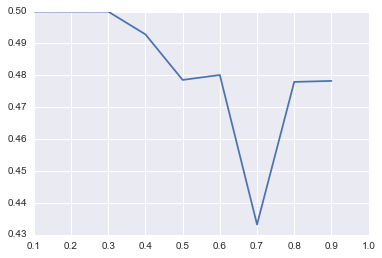

In [17]:
plt.plot(thresholds, oos_scores);

In [ ]:
## Prediction
clf = LogisticRegression(C=0.1, solver='liblinear')
clf.fit(X, y)

In [ ]:
predictions = clf.predict(test)

In [ ]:
def encode_labels(prediction):
    if prediction == 1:
        return 'Y'
    else:
        return 'N'
    
predictions_encoded = map(encode_labels, predictions)

In [ ]:
sub.loc[: ,'Loan_ID'] = test_loan_ids
sub.loc[:, 'Loan_Status'] = predictions_encoded

In [ ]:
sub.head()

In [ ]:
sub.to_csv('./submissions/baseline_submission.csv', index=False)